<span style="font-size: 14pt">MIPT, Applied ML, Autumn 2018</span>

<span style="font-size: 16pt"> Seminars #11: Recommendational Systems: Intro

<span style="color:blue; font-size: 12pt">Iurii Efimov </span>
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">yuri.efimov@phystech.edu</span>

**Key words:** 
    - recommendational systems (RS), user-item matrix
    - non-personalized RS, content-based RS, collaborative filtering
    - top-k metrics, ranking quality, DCG, nDCG


<h3> Plan </h3>

  * **Recap: Basic ideas** (20 minutes)
      - User-item matrix
      - Features
      - Metrics
      
  
  * **Simple RS** (40 minutes)
      - non-personalized (10 minutes)
      - content-based (10 minutes)
      - user-item matrix analysis (10 minutes)
      - collaborative filtering (10 minutes)
  
  
  * **RS libraries** (5 minutes)

<h1 align="center">RS basics</h1>
 
**Ключевые понятия:**
 * $u\in \mathcal{U}$ - users, пользователи
 
 * $i \in \mathcal{I}$ - items, товары
 
 * $\exists r_{u,i}\in \mathbb{R}$ - ratings, оценка товара $i$ пользователем $u$
 
 * $R = || r_{u,i} ||$ - матрица кросс-табуляции (user-item) $|U|\times |I|$.


**Задача:**
Для пары (u,i) по имеющимся оценкам $\{r_{u',i'}\}_{u',i'}$ предсказывать степень заинтересованности $r_{u,i}$.

<img src="./images/lady.jpg" align="right" width="300" />


**Признаки и подходы к решению:**

 * Non-personalized
 * Content-based
 * Collaborative filtering:
     * User-based
     * Item-based
 
**Метрики:**
 * Из задач регрессии: MSE, RMSE, MAE etc.
 * Из задач классификации: accuracy, precision, recall, AUC-ROC, AUC-PRC etc.
 * TOP-K метрики: hitrate@k, precision@k, recall@k
 * Оценка качества ранжирования: DCG@k, nDCG@k
 * etc.

<h2 align="center">Dataset example</h2>

In [2]:
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix, csr_matrix, csc_matrix
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Рассмотрим один из самых известых и популярных датасетов: **MovieLens**

Ссылка: https://grouplens.org/datasets/movielens/

Датасет представляет из себя набор рейтингов фильмов, а также другую сопутствующую информацию: теги фильмов, ссылки на них на IMDB и тд. Датасеты есть разных размеров, мы поисследуем датасет 2016 года, в нем 20 миллионов оценок, 27000 фильмов и 138000 пользователей.

In [3]:
df = pd.read_csv("ml-20m/ratings.csv")

In [4]:
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [5]:
print("Max user id", df["userId"].max())
print("Max item id", df["movieId"].max())

Max user id 138493
Max item id 131262


In [6]:
print("Unique user count", len(df["userId"].unique()))
print("Unique movie count", len(df["movieId"].unique()))

Unique user count 138493
Unique movie count 26744


Номера фильмов идут не подряд, для удобства перенумеруем фильмы по порядку

In [7]:
index_to_item_id_mapping = [x for x in df["movieId"].sort_values().unique()]
item_id_to_index_mapping = {}
for index, value in enumerate(index_to_item_id_mapping, start=1):
    item_id_to_index_mapping[int(value)] = index

assert len(index_to_item_id_mapping) == 26744

In [8]:
df = pd.DataFrame.from_records(
    {"userId": row.userId, "movieId": item_id_to_index_mapping[int(row.movieId)], "rating": row.rating}
    for row in df.itertuples())

In [9]:
df.shape

(20000263, 3)

Как говорилось на лекции, центральный предмет изучения в рекомендательных системах это матрица user-item.

Разреженность большая: 20000263 / (138493 * 26744) = 0.005

Если восстанавливать ее всю, то это ~ 138493 x 26744 x 4 (размер float) = 13 gb.

In [10]:
# cross-validation 
def run_cv(predictor_class, fold_count=5, top_size=10):
    users = list(range(len(df["userId"].unique())))
    fold_size = len(users) // fold_count

    results = []

    for fold_start in range(fold_count):
        fold = users[fold_start:fold_start+fold_size]

        df["random"] = np.random.random(size=(df.shape[0], 1))
        idx = df.sort_values(by="random") \
            .reset_index() \
            .groupby("userId") \
            .last()["index"]

        mask = df.index.isin(idx) & df["userId"].isin(fold)
        train_df = df[~mask]
        test_df = df[mask]

        predictor = predictor_class(train_df, test_df, top_size)
        
        sum_ = 0.0
        for row in test_df.itertuples():
            prediction = predictor.predict(row)
            if prediction is None:
                continue
                
            sum_ += float(row.movieId in prediction)

        results.append(sum_ / test_df.shape[0])
    
    return np.mean(results)

<h2 align="center">Simple RS: Non-personalized</h2>

Реализуем три метода non-personalized метода рекомендаций:
1. Будем предсказывать топ-10 наиболее популярных фильмов (популярность - число рейтингов)
2. Будем предсказывать топ-10 наиболее рейтинговых фильмов (с самым большим средним рейтингом)
3. Будем предсказывать топ-10 случайных фильмов (каждый раз перемешивая список при предсказании)

Сравним эти методы по метрике HitRate с помощью CV:
$$HR = \frac{\#hits}{\#users}$$

Первый метод, предсказываем топ-10 наиболее популярных фильмов

In [11]:
class PopularityPredictor(object):
    def __init__(self, train_df, test_df, top_k=10):
        self.top_k = top_k
        ## implement me, please
        self.top = list(train_df
            .groupby("movieId")
            .size()
            .reset_index()
            .sort_values(by=0, ascending=False)
            .iloc[:top_k]["movieId"]
            .values)
        ##

    def predict(self, row):
        return self.top

Второй метод, предсказываем топ-10 фильмов с наибольшим средним рейтингом

In [12]:
class AvgRatingPredictor(object):
    def __init__(self, train_df, test_df, top_k=10, rating_num_threshold=5):
        group_sizes = train_df.groupby("movieId").size().reset_index()
        # не будем рассматривать фильмы, которые были редко оценены
        blacklist = group_sizes[group_sizes[0] < rating_num_threshold].movieId
        train_df = train_df[~train_df.movieId.isin(blacklist)]
        ## implement me, please
        self.top = list(train_df
            .groupby("movieId")
            .mean()
            .reset_index()
            .sort_values(by="rating", ascending=False)
            .iloc[:top_k]["movieId"]
            .values)
    
    def predict(self, row):
        return self.top

Третий метод, предсказываем случайные 10 фильмов

In [13]:
class RandomPredictor(object):
    def __init__(self, train_df, test_df, top_k=10):
        self.top_k=top_k
        self.movies = list(range(len(train_df["movieId"].unique())))
    
    def predict(self, row):
        np.random.shuffle(self.movies)
        return self.movies[:self.top_k]

Сравним результаты:

In [14]:
%%time

print("Popularity predictor: {:.4f}".format(run_cv(PopularityPredictor)))
print("Average rating predictor: {:.4f}".format(run_cv(AvgRatingPredictor)))
print("Random predictor: {:.4f}".format(run_cv(RandomPredictor)))

Popularity predictor: 0.0505
Average rating predictor: 0.0133
Random predictor: 0.0005
Wall time: 6min 10s


<h2 align="center">Simple RS: Content-based</h2>

Будем использовать информацию о фильмах для предсказания, а именно - жанр фильмов.
1. Посмотрим на самые популярные жанры
2. Внутри каждого жанра найдем топ-10 самых популярных фильмов
3. Для каждого пользователя определим топ-3 жанров, которые он смотрит
4. Построим простую content-based систему, предсказывая для каждого пользователя 5 самых популярных фильмов из первого по популярности жанра, 3 фильма второго по популярности жанра и 2 фильма из третьего по популярности жанра
5. Посчитаем HitRate

In [15]:
df_movie = pd.read_csv("ml-20m/movies.csv")

In [16]:
from collections import Counter, defaultdict

genres = []

for row in df_movie.itertuples():
    genre_list = row.genres.split("|")
    genres.extend(genre_list)

cntr = Counter(genres)

In [17]:
cntr

Counter({'Adventure': 2329,
         'Animation': 1027,
         'Children': 1139,
         'Comedy': 8374,
         'Fantasy': 1412,
         'Romance': 4127,
         'Drama': 13344,
         'Action': 3520,
         'Crime': 2939,
         'Thriller': 4178,
         'Horror': 2611,
         'Mystery': 1514,
         'Sci-Fi': 1743,
         'IMAX': 196,
         'Documentary': 2471,
         'War': 1194,
         'Musical': 1036,
         'Western': 676,
         'Film-Noir': 330,
         '(no genres listed)': 246})

In [18]:
cntr.most_common(5)

[('Drama', 13344),
 ('Comedy', 8374),
 ('Thriller', 4178),
 ('Romance', 4127),
 ('Action', 3520)]

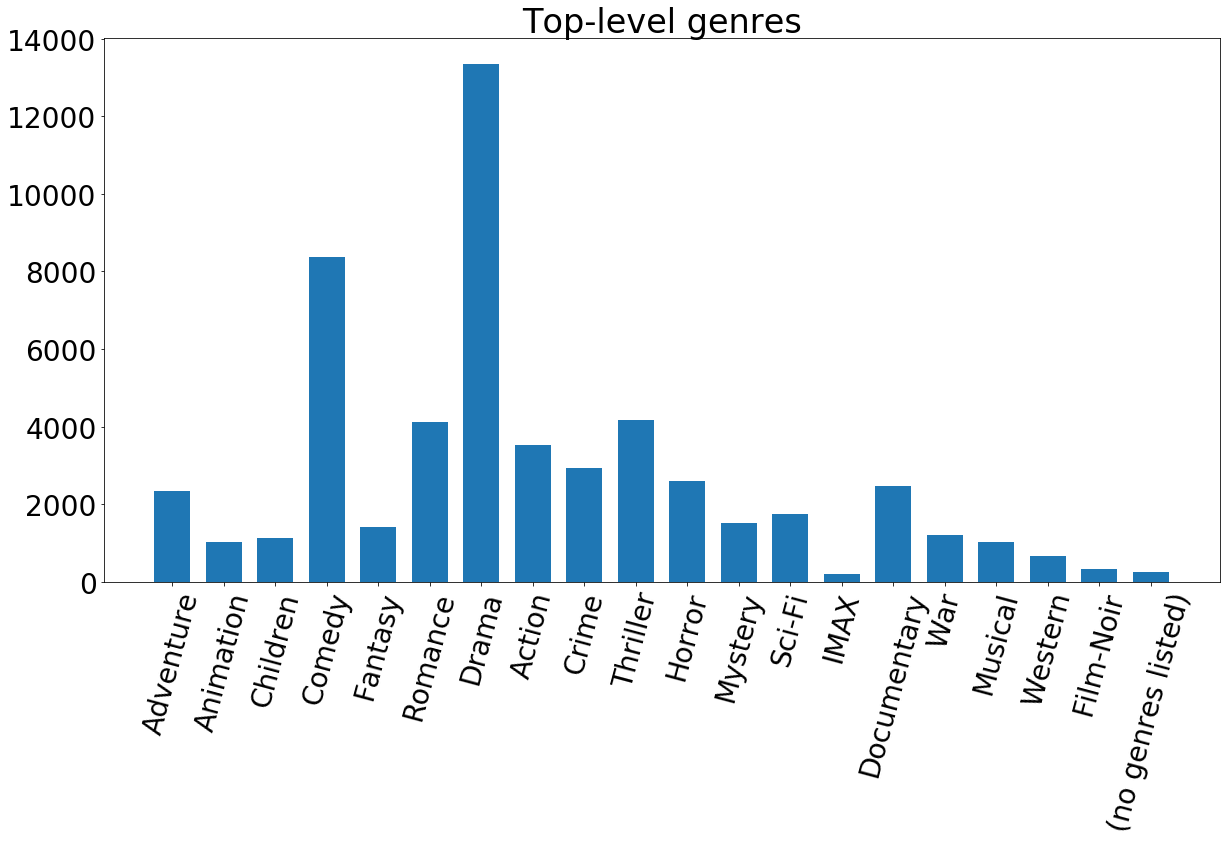

In [19]:
import matplotlib

matplotlib.rcParams.update({'font.size': 28})

plt.figure(figsize=(20,10))
hist, bins = np.histogram(list(cntr.values()), bins=len(cntr))
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

plt.bar(center, cntr.values(), align='center', width=width, tick_label=list(cntr.keys()))
plt.xticks(rotation=75)
_ = plt.title('Top-level genres')

In [20]:
df_joined = pd.merge(df, df_movie[["movieId", "genres"]], on="movieId", how="inner")

In [21]:
def genre_list(x):
    return list(set("|".join(x.tolist()).split("|")))

def genre_list_len(x):
    return len(genre_list(x))

def popular_genres(x):
    return Counter("|".join(x.tolist()).split("|")).most_common(3)

df_users = df_joined.groupby('userId').agg({'genres': [genre_list, genre_list_len, popular_genres]})

In [22]:
df_users.head()

genres                 \
                                               genre_list genre_list_len   
userId                                                                     
1       [Fantasy, IMAX, Action, Adventure, Film-Noir, ...             19   
2       [Fantasy, Action, Adventure, Documentary, Chil...             17   
3       [Fantasy, Action, Adventure, Film-Noir, Thrill...             18   
4       [Fantasy, IMAX, Action, Adventure, Film-Noir, ...             16   
5       [Fantasy, Action, IMAX, Adventure, Film-Noir, ...             17   

                                                     
                                     popular_genres  
userId                                               
1        [(Drama, 77), (Comedy, 49), (Romance, 31)]  
2        [(Drama, 34), (Comedy, 21), (Romance, 13)]  
3       [(Drama, 94), (Comedy, 55), (Thriller, 40)]  
4           [(Drama, 13), (Comedy, 8), (Action, 8)]  
5        [(Drama, 39), (Comedy, 25), (Romance, 16)]

In [23]:
# Sanity-check, что join отработал верно
df_joined[df_joined["userId"] == 1].head()

,movieId,rating,userId,random,genres
0,2,3.5,1,0.306778,Adventure|Children|Fantasy
22243,29,3.5,1,0.541975,Adventure|Drama|Fantasy|Mystery|Sci-Fi
30763,32,3.5,1,0.023884,Mystery|Sci-Fi|Thriller
75743,47,3.5,1,0.267540,Mystery|Thriller
118992,50,3.5,1,0.812469,Crime|Mystery|Thriller


In [24]:
df_counts = df_joined.groupby("movieId").count().reset_index()
df_counts["count"] = df_counts["rating"]
for col in ("userId", "random", "genres", "rating"):
    del df_counts[col]

In [25]:
result = pd.merge(df_joined, df_counts, on="movieId")

In [26]:
result.head()

,movieId,rating,userId,random,genres,count
0,2,3.5,1,0.306778,Adventure|Children|Fantasy,22243
1,2,3.0,5,0.554055,Adventure|Children|Fantasy,22243
2,2,3.0,13,0.493669,Adventure|Children|Fantasy,22243
3,2,3.0,29,0.516780,Adventure|Children|Fantasy,22243
4,2,3.0,34,0.978628,Adventure|Children|Fantasy,22243


In [27]:
genre_to_movies = defaultdict(set)

for row in result.itertuples():
    genres = row.genres.split("|")
    for genre in genres:
        genre_to_movies[genre].add((row.movieId, row.count))

In [28]:
genre_to_top_movies = {}

for k, v in genre_to_movies.items():
    genre_to_top_movies[k] = sorted(list(v), key=lambda p: -p[1])[:10]

In [29]:
df_users_new = df_users.reset_index()

In [30]:
class ContentBasedPredictor(object):
    def __init__(self, train_df, test_df, top_size=10):
        pass
    
    def predict(self, row):
        top = list(df_users_new[df_users_new["userId"] == row.userId][("genres", "popular_genres")])
        
        if not top:
            return
        
        top_genres = [k for k, _ in top[0]]
        recommendations = []
        
        i_to_size = {0: 5, 1: 3, 2: 2}
        for i, genre in enumerate(top_genres):
            for movie, _ in genre_to_top_movies[genre][:i_to_size[i]]:
                recommendations.append(movie)
        
        return recommendations

In [31]:
%%time
print("Content-based predictor: {:4f}".format(run_cv(ContentBasedPredictor)))

Content-based predictor: 0.043982
Wall time: 6min 7s


**Question**: В каком случае имеет смысл использовать content-based подходы?

**Answer**: Холодный старт

<h1 align="center"> Simple RS: Similar movies</h1>

In [32]:
df_links = pd.read_csv("ml-20m/links.csv")
df_movies_joined = pd.merge(df_movie, df_links, on="movieId")

In [33]:
from scipy.sparse import issparse

def compute_similarity_matrix(m):
    sim = m.T.dot(m)
    
    # Это должно уместиться в памяти :)
    if issparse(sim):
        sim = sim.todense()
    
    sim = sim + 1e-9
    norms = np.array(np.sqrt(np.diagonal(sim)))
    return sim / norms / norms.T

def find_top_similar_movies(movie_id, similarity_matrix, k=10):
    indices = np.asarray(np.argsort(similarity_matrix[movie_id, :])).reshape(-1)[-k:-1]
    transformed_indices = [index_to_item_id_mapping[z] for z in indices]
    return df_movies_joined[df_movies_joined["movieId"].isin(transformed_indices)]

Воспользуемся для матрицы user-item sparse-представлением

In [34]:
M = csc_matrix(
    (df["rating"], (df["userId"] - 1, df["movieId"] - 1)))

Для метрики сходства используем cosine similarity.

In [35]:
cs = cosine_similarity(M.T)

Что ещё можно использовать здесь, вместо cosine_similarity?

In [36]:
import requests
from IPython.display import Image, display

# Инструкция как получить свой токен: https://developers.themoviedb.org/3/getting-started/introduction
API_KEY = "5b6cf33b91eb09338d2d7816329f52fc"
TMDB_URL = "https://api.themoviedb.org/3/movie/{}/images?api_key={}"

cfg = requests.get("http://api.themoviedb.org/3/configuration",
                   params={"api_key": API_KEY}, headers={"Content-Type": "application/json"})
cfg.raise_for_status()
cfg_json = cfg.json()

base_url = cfg_json["images"]["base_url"] + "w185"

def get_top_similar_movies_posters(similar_movies_df):
    posters = []

    for movie in similar_movies_df.itertuples():
        url = TMDB_URL.format(int(movie.tmdbId), API_KEY)
        rsp = requests.get(url)
        rsp.raise_for_status()
        info = rsp.json()

        poster = info["posters"][0]["file_path"]
        posters.append(Image(url=base_url + poster))
    
    return posters

Найдём фильмы, похожие на фильм с id=0 (История игрушек)

In [37]:
similar_movies = find_top_similar_movies(0, cs) 

In [38]:
similar_movies

,movieId,title,genres,imdbId,tmdbId
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,76759,11.0
352,356,Forrest Gump (1994),Comedy|Drama|Romance|War,109830,13.0
476,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,107290,329.0
582,588,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical,103639,812.0
640,648,Mission: Impossible (1996),Action|Adventure|Mystery|Thriller,117060,954.0
767,780,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller,116629,602.0
1184,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,86190,1892.0
1242,1270,Back to the Future (1985),Adventure|Comedy|Sci-Fi,88763,105.0
3027,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,120363,863.0


In [39]:
display(*get_top_similar_movies_posters(similar_movies))

Получим латентные вектора через SVD разложение

In [40]:
from scipy.sparse.linalg import svds

U, S, Vt = svds(M, k=30)
cs_svd = cosine_similarity(Vt.T)

In [41]:
similar_movies_svd = find_top_similar_movies(0, cs_svd)

In [42]:
similar_movies_svd

,movieId,title,genres,imdbId,tmdbId
105,107,Muppet Treasure Island (1996),Adventure|Children|Comedy|Musical,117110,10874.0
603,609,Homeward Bound II: Lost in San Francisco (1996),Adventure|Children,116552,25059.0
624,631,All Dogs Go to Heaven 2 (1996),Adventure|Animation|Children|Fantasy|Musical|R...,115509,19042.0
653,661,James and the Giant Peach (1996),Adventure|Animation|Children|Fantasy|Musical,116683,10539.0
699,711,Flipper (1996),Adventure|Children,116322,36355.0
813,828,"Adventures of Pinocchio, The (1996)",Adventure|Children,115472,18975.0
1336,1367,101 Dalmatians (1996),Adventure|Children|Comedy,115433,11674.0
2270,2355,"Bug's Life, A (1998)",Adventure|Animation|Children|Comedy,120623,9487.0
3027,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,120363,863.0


In [43]:
display(*get_top_similar_movies_posters(similar_movies_svd))

Рассмотрим другой фильм: Spider-Man

In [44]:
similar_movies_svd_sm = find_top_similar_movies(item_id_to_index_mapping[5349] - 1, cs_svd)

In [45]:
similar_movies_svd_sm

,movieId,title,genres,imdbId,tmdbId
3702,3793,X-Men (2000),Action|Adventure|Sci-Fi,120903,36657.0
4800,4896,Harry Potter and the Sorcerer's Stone (a.k.a. ...,Adventure|Children|Fantasy,241527,671.0
4867,4963,Ocean's Eleven (2001),Crime|Thriller,240772,161.0
5281,5378,Star Wars: Episode II - Attack of the Clones (...,Action|Adventure|Sci-Fi|IMAX,121765,1894.0
5348,5445,Minority Report (2002),Action|Crime|Mystery|Sci-Fi|Thriller,181689,180.0
6234,6333,X2: X-Men United (2003),Action|Adventure|Sci-Fi|Thriller,290334,36658.0
6260,6365,"Matrix Reloaded, The (2003)",Action|Adventure|Sci-Fi|Thriller|IMAX,234215,604.0
6429,6539,Pirates of the Caribbean: The Curse of the Bla...,Action|Adventure|Comedy|Fantasy,325980,22.0
7953,8636,Spider-Man 2 (2004),Action|Adventure|Sci-Fi|IMAX,316654,558.0


In [46]:
display(*get_top_similar_movies_posters(similar_movies_svd_sm))

<h2 align="center"> Simple RS: Collaborative Filtering</h2>

In [47]:
class ErrorAggregator(object):
    def __init__(self):
        self.sum_ = 0.0
        self.count = 0
        
    def add_value(self, x, count):
        self.sum_ += x
        self.count += count
        
    def get_rmse(self):
        return np.sqrt(self.sum_ / (self.count - 1))

In [48]:
import time

df["random"] = np.random.random(size=(df.shape[0], 1))
idx = df.sort_values(by="random") \
    .reset_index() \
    .groupby("userId") \
    .head(n=7)["index"]

mask = df.index.isin(idx)
train_df = df[~mask]
test_df = df[mask]
    
train_M = csr_matrix(
    (train_df["rating"], (train_df["userId"] - 1, train_df["movieId"] - 1)), shape=(138493, 26744))

train_M_mean = train_M.mean()

U, S, Vt = svds(train_M, k=30)

svd_error = ErrorAggregator()
mean_error = ErrorAggregator()
times = []

for user_id, group in test_df.groupby("userId"):
    start_time = time.time()
    
    uvec = U[user_id - 1, :] * S
    
    movie_ids = group["movieId"] - 1
    ratings = group["rating"]
    
    diff = (uvec.dot(Vt[:, movie_ids]) - ratings.values) ** 2
    svd_error.add_value(np.sum(diff), len(diff))
    
    mean_diff = (ratings.values - train_M_mean) ** 2
    mean_error.add_value(np.sum(mean_diff), len(mean_diff))
    
    times.append(time.time() - start_time)

print("RMSE:", svd_error.get_rmse())
print("Random RMSE:", mean_error.get_rmse())
print("Average evaluation time:", np.mean(times))

RMSE: 2.996173368869037
Random RMSE: 3.7635227542448826
Average evaluation time: 0.00022329209924108303


Построим рекомендации для userId=10

In [49]:
len(df[df["userId"] == 10])

38

In [52]:
tenth_user_movies = pd.merge(df[df["userId"] == 10], df_movie, on="movieId")
tenth_user_movies.head(10)

,movieId,rating,userId,random,title,genres
0,1,4.0,10,0.983422,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,11,4.0,10,0.452083,"American President, The (1995)",Comedy|Drama|Romance
2,25,4.0,10,0.245786,Leaving Las Vegas (1995),Drama|Romance
3,258,4.0,10,0.096925,"Kid in King Arthur's Court, A (1995)",Adventure|Children|Comedy|Fantasy|Romance
4,353,3.0,10,0.548313,"Crow, The (1994)",Action|Crime|Fantasy|Thriller
5,524,5.0,10,0.479627,Rudy (1993),Drama
6,844,5.0,10,0.128514,"Story of Xinghua, The (Xinghua san yue tian) (...",Drama
7,896,4.0,10,0.714297,Wild Reeds (Les roseaux sauvages) (1994),Drama
8,953,4.0,10,0.613473,It's a Wonderful Life (1946),Drama|Fantasy|Romance
9,1073,3.0,10,0.208966,Willy Wonka & the Chocolate Factory (1971),Children|Comedy|Fantasy|Musical


In [53]:
t = (U[9, :] * S).dot(Vt)

In [54]:
recommendations = np.argsort(t).tolist()

In [56]:
films = []

for r in recommendations[-100:]:
    if r + 1 not in tenth_user_movies["movieId"].values:  # Не рекомендуем то, что пользователь уже смотрел
        films.append(r)

filtered_movies = df_movies_joined[df_movies_joined["movieId"].isin([index_to_item_id_mapping[x] for x in films])]

In [57]:
display(*get_top_similar_movies_posters(filtered_movies))

## RS libraries review

a. https://docs.scipy.org/doc/scipy/reference/sparse.html

scipy.sparse и scipy.sparse.linalg.svds :)

Можно делать коллаборативную фильтрацию подсчитывая svd разложение на разреженных матрицах. Примеров в интернете полно, про сам метод будет рассказано на лекциях.

b. http://mendeley.github.io/mrec/

Умеет подготавливать выборку, умеет считать разные популярные метрики такие как HitRate, Recall. Набор стандартных алгоритмов:

kNN (user/item based)
popularity
SLIM, WARP, WRMF
c. http://libfm.org/

Эффективная реализация модели факторизационных машин. Алгоритмы SGD, ALS.

d. GraphLab Collaborative Filtering Toolkit (https://turi.com/products/create/docs/graphlab.toolkits.recommender.html)

Умеет SVD (ALS, SGD), SVD++, Weighted-ALS, non-negative matrix factorization.

e. Vowpal Wabbit (https://github.com/JohnLangford/vowpal_wabbit/wiki/Matrix-factorization-example)

Можно использовать разложение матрички оттуда.

## RS matrix factorization

a. http://libfm.org/

Эффективная реализация модели факторизационных машин. Алгоритмы SGD, ALS.

b. GraphLab Collaborative Filtering Toolkit (https://turi.com/products/create/docs/graphlab.toolkits.recommender.html)

Умеет SVD (ALS, SGD), SVD++, Weighted-ALS, non-negative matrix factorization.

c. Vowpal Wabbit (https://github.com/JohnLangford/vowpal_wabbit/wiki/Matrix-factorization-example)

Можно использовать разложение матрички оттуда.

## Summary

1. Познакомились с датасетом MovieLens
2. Построили несколько простых моделей для рекомендаций
3. Построена рекомендательная модель для каждого фильма с помощью косинусной близости
4. Построена рекомендательная система на основе SVD
5. Познакомились с библиотеками для CF & MF
6. Познакомились с распространенными библиотеками для построения рекомендательных систем

Обратная связь и ДЗ: 'insert link'